<a href="https://colab.research.google.com/github/kimhwijin/computer_vision_assignment/blob/main/train_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [ ]:
!git clone https://github.com/kimhwijin/computer_vision_assignment.git

Cloning into 'computer_vision_assignment'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 491 (delta 99), reused 130 (delta 60), pack-reused 314
Receiving objects: 100% (491/491), 8.30 MiB | 7.53 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [ ]:
!unzip /content/drive/MyDrive/Dataset/GI-tract/row-data.zip -d /content/computer_vision_assignment/Project2
from IPython import display
display.clear_output()

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 4.1 MB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
albumentations==1.1.0 is successfully installed


In [ ]:
!curl https://colab.chainer.org/install | sh -
!pip install cucim
!pip install scipy scikit-image cupy-cuda100
from IPython import display
display.clear_output()

In [ ]:
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 3.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


# Import

In [ ]:
import pandas as pd
import sys
import numpy as np
import cupy as cp
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import random
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from collections import defaultdict

sys.path.append("/content/computer_vision_assignment/Project2")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%reload_ext autoreload
from config import Config
from model.unet import get_unet_model
from preprocess.dataframe.split import create_kfold_train_validation_dataframe
from preprocess.dataframe.transform import get_train_csv_and_transform
from dataset.dataset import make_dataset, make_full_path_from_transformed_df
from model import unet
from loss.loss import focal_tversky, dice_coefficient, dice_loss, tversky_index, tversky_loss

In [ ]:
df = get_train_csv_and_transform()
train_df, valid_df = create_kfold_train_validation_dataframe(df)

train_paths = make_full_path_from_transformed_df(train_df)
valid_paths = make_full_path_from_transformed_df(valid_df)

train_dataset = make_dataset(train_paths, augment=True)
valid_dataset = make_dataset(valid_paths, augment=False)

train_dataset = train_dataset.repeat(3)

n train :  33664
n valid :  4832


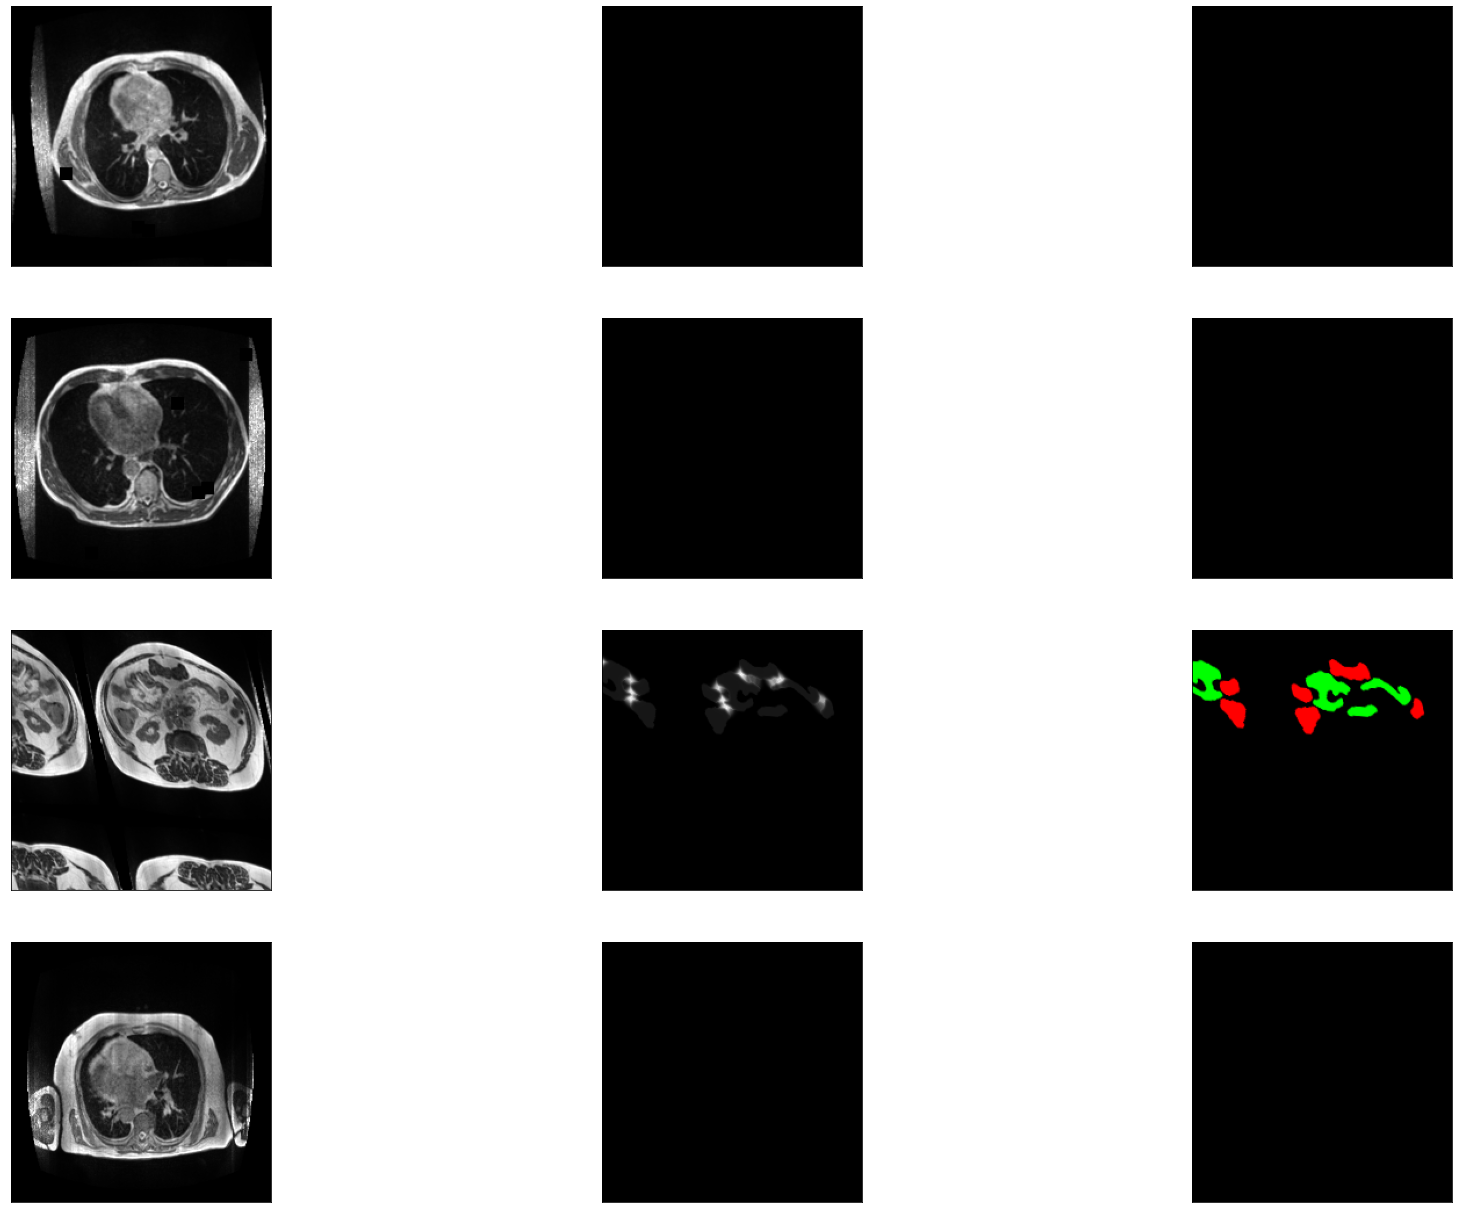

In [ ]:
for (x,y),z in train_dataset.take(1):
    fig = plt.figure(figsize=(30, 22))
    n = x.shape[0]
    for i in range(n):
        if i > 3:
            break
        ax = fig.add_subplot(4, 3, 3*i+1, xticks=[], yticks=[])
        ax.imshow(x[i,:,:,0], 'gray')
        # ax.set_title(f"Label: {label[i]}")

        ax = fig.add_subplot(4, 3, 3*i+2, xticks=[], yticks=[])
        ax.imshow(y[i,:,:,0], 'gray')
        # ax.set_title(f"Label: {label[i]}")

        ax = fig.add_subplot(4, 3, 3*i+3, xticks=[], yticks=[])
        ax.imshow(z[i])
        # ax.set_title(f"Label: {label[i]}")


In [ ]:
train_step = len(train_dataset)
valid_step = len(valid_dataset)
EPOCHS = 30
print("one epoch train step : ", train_step)
print("one epoch valid step : ", valid_step)
initial_learning_rate = Config.INIT_LEARNING_RATE
decay_steps=EPOCHS*train_step
lr_decayed_fn = keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps, alpha=0.002)

one epoch train step :  4209
one epoch valid step :  202


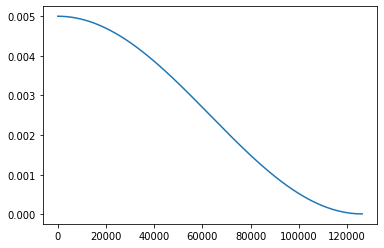

In [ ]:
a = []
for i in range(decay_steps):
    a.append(lr_decayed_fn(i))
plt.plot(range(decay_steps), a)

In [ ]:
a[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0000001e-05>

In [ ]:
def binary_crossentropy_with_weight(y_true, y_pred, weight_map):
    return -weight_map * (y_true * K.log(y_pred+K.epsilon()) + (1-y_true) * K.log(1-y_pred+K.epsilon()))

def binary_focal_crossentropy_with_weight(y_true, y_pred, weight_map, gamma=2.0):
    p_t = y_true * y_pred + (1-y_true)*(1-y_pred)
    focal_factor = tf.pow(1. - p_t, gamma)
    return focal_factor * binary_crossentropy_with_weight(y_true, y_pred, weight_map)

In [ ]:
@tf.function
def loss_fn(y_true, y_pred, x_weight_map):
    f_bce_w = binary_focal_crossentropy_with_weight(y_true, y_pred, x_weight_map)
    bce_loss_value = K.mean(f_bce_w)
    tversky_loss_value = tversky_loss(y_true, y_pred)
    return 0.5 * bce_loss_value + 0.5 * tversky_loss_value

In [ ]:
model = unet.get_unet_model()
optimizer = keras.optimizers.Adam(lr_decayed_fn)
model.compile(optimizer=optimizer)

In [ ]:
def train_one_epoch():

    running_loss_value = 0.0
    pbar = tqdm(enumerate(train_dataset), total=train_step, desc='Train ')
    for step, ((x_image,x_weight_map), y_mask) in pbar:
        with tf.GradientTape() as tape:
            y_pred = model(x_image, training=True)
            loss_value = loss_fn(y_mask, y_pred, x_weight_map)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        #
        running_loss_value += (loss_value.numpy() * Config.BATCH_SIZE)
        epoch_loss_value = running_loss_value / Config.BATCH_SIZE
        current_lr = optimizer.learning_rate(step)
        pbar.set_postfix(train_loss=f'{epoch_loss_value:0.4f}',lr=f'{current_lr:0.5f}')
    gc.collect()
    return epoch_loss_value

In [ ]:
def valid_one_epoch():
    running_loss_value = 0.0

    scores = []
    pbar = tqdm(enumerate(valid_dataset), total=valid_step, desc='Valid ')
    for step, ((x_image,x_weight_map), y_mask) in pbar:
        y_pred = model(x_image, training=False)
        loss_value = loss_fn(y_mask, y_pred, x_weight_map)
    
        running_loss_value += (loss_value.numpy() * Config.BATCH_SIZE)
        epoch_loss_value = running_loss_value / Config.BATCH_SIZE

        dice_scores = dice_coefficient(y_true, y_pred)
        scores.append(dice_scores)
        pbar.set_postfix(valid_loss=f'{epoch_loss_value:0.4f}')
    scores = np.mean(scores,axis=0)
    gc.collect()
    return epoch_loss_value, scores

In [ ]:
best_epoch = -1
best_dice = -np.inf
history = defaultdict(list)

for epoch in range(1, EPOCHS+1):
    gc.collect()
    print(f'Epoch {epoch}/{EPOCHS}')
    train_loss = train_one_epoch()
    valid_loss, scores = valid_one_epoch()
    dice_score = scores
    
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['valid_dice'].append(dice_score)
    print(f'Valid Dice: {dice_score:0.4f}')
    if dice_score >= best_dice:
        print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
        best_dice    = dice_score
        best_epoch   = epoch
        model.save('/content/drive/MyDrive/unet_best_dice_{:.2f}.h5'.format(dice_score))


Epoch 1/30

Train :  14%|█▍        | 600/4209 [07:17<41:51,  1.44it/s]